In [ ]:
# Uncomment and run this cell if you're running in Google Colab.
# !pip install splink

<a target="_blank" href="https://colab.research.google.com/github/moj-analytical-services/splink/blob/master/docs/demos/examples/duckdb_no_test/business_rates_match.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a> 

### Matching businesses

In this example we attempt to match open business rates data from Stockport ([source](https://www.data.gov.uk/dataset/f027145b-b55f-4602-b889-b28a8ca04462/stockport-council-business-rates)) with Companies House data ([source](https://download.companieshouse.gov.uk/en_output.html)).

This is quite a challenging scenario because the data is not initially well suited for Splink.

First, there are only three columns to match on:

- The business name
- The address
- The business postcode

Second, the data itself is quite different to many other applications: the business name is an ordered 'bag of words'.

We will therefore need to use a few preprocessing tricks to build a successful matching model/

Let's start by taking a look at the data. To make the size of these files manageable, I have [selected only](https://github.com/RobinL/company_matching_example/blob/main/business_rates_gen_data.py) rows from the companies house data where `substr(postcode, 1,4)` matches at least one postcode in the Stockport data, resulting in:

- Companies house data is around 1 million records
- Stockport data has 4,540 records

In this example, to make it easy to understand, I break the calculation into multiple steps.  Many calculations can be combined into single steps - you can see a more condensed version [here](https://github.com/RobinL/company_matching_example/blob/main/business_rates_working_example.py).

First, let's take a look at the data:


In [1]:
import duckdb
import altair as alt

df_companies_house = duckdb.read_parquet("https://github.com/RobinL/company_matching_example/raw/refs/heads/main/companies_house.parquet")
df_companies_house.sort("company_name").show(max_rows=5)

df_stockport_business_rates = duckdb.read_parquet("https://github.com/RobinL/company_matching_example/raw/refs/heads/main/stockport_business_rates.parquet")
df_stockport_business_rates.sort("company_name").show(max_rows=5)



┌──────────────────────────────┬────────────────┬─────────────────────────────────────────┬──────────┐
│         company_name         │ company_number │             address_concat              │ postcode │
│           varchar            │    varchar     │                 varchar                 │ varchar  │
├──────────────────────────────┼────────────────┼─────────────────────────────────────────┼──────────┤
│ ! LTD                        │ 08209948       │ 9 PRINCES SQUARE                        │ HG1 1ND  │
│ !BIG IMPACT GRAPHICS LIMITED │ 11743365       │ 372 OLD STREET 335 ROSDEN HOUSE         │ EC1V 9LT │
│ !NFOGENIE LTD                │ 13522064       │ 71-75 SHELTON STREET                    │ WC2H 9JQ │
│       ·                      │    ·           │       ·                                 │    ·     │
│       ·                      │    ·           │       ·                                 │    ·     │
│       ·                      │    ·           │       ·                

## Feature engineering 

We will do some feature engineering to make this data more amenable to matching:

- To match companies, we will tokenise the company name and compute the term frequencies of each token.  This will allow us to more accurately quantify how closely two business names match
- We will also pick out a subset of tokens to give us access to new blocking strategies
- To match addresses, we will use the first number in the address and the postcode only.  This is simplistic - for a more advanced approach to address matching in Splink see [here](https://github.com/RobinL/uk_address_matcher/) 

We'll perform this featuring on both datasets simultaneously to ensure the token frequencies are representative of all the data

In [2]:
# Start by creating a table with the data vertically concatenated
sql = """
create or replace table all_input_data as
with concat_data as (
    select *, 'stockport' as source_dataset

from df_stockport_business_rates
union all
select *, 'z_all_companies' as source_dataset
from df_companies_house
)
select ROW_NUMBER() OVER () as unique_id, *
from concat_data
"""

duckdb.execute(sql)

duckdb.table("all_input_data").show(max_rows=10, max_width=100000)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬──────────────────────────────┬────────────────┬──────────────────────────────────────────────────────────────────────────┬──────────┬─────────────────┐
│ unique_id │         company_name         │ company_number │                              address_concat                              │ postcode │ source_dataset  │
│   int64   │           varchar            │    varchar     │                                 varchar                                  │ varchar  │     varchar     │
├───────────┼──────────────────────────────┼────────────────┼──────────────────────────────────────────────────────────────────────────┼──────────┼─────────────────┤
│         1 │ 08 UK LTD                    │ NULL           │ 15 MADOC STREET LLANDUDNO CONWY WALES                                    │ LL30 2TL │ stockport       │
│         2 │ 1 GR LTD                     │ NULL           │ 296-296A GORTON ROAD REDDISH STOCKPORT                                   │ SK5 6RN  │ stockport       │
│   

In [3]:
# Tokenize company names, and explode tokens across rows
# The tokenisation approach here is simplistic, more advanced strategies could be used
# in a more fully-fledged application


sql = """
CREATE OR REPLACE TABLE unnested AS
SELECT
    unique_id,
    unnest(regexp_split_to_array(upper(trim(company_name)), '\\s+')) as name_token,
    generate_subscripts(regexp_split_to_array(upper(trim(company_name)), '\\s+'), 1) as token_position_in_name
FROM all_input_data
"""

unnested = duckdb.execute(sql)
duckdb.table("unnested").show(max_rows=10, max_width=100000)


┌───────────┬────────────┬────────────────────────┐
│ unique_id │ name_token │ token_position_in_name │
│   int64   │  varchar   │         int64          │
├───────────┼────────────┼────────────────────────┤
│         1 │ 08         │                      1 │
│         1 │ UK         │                      2 │
│         1 │ LTD        │                      3 │
│         2 │ 1          │                      1 │
│         2 │ GR         │                      2 │
│         · │ ·          │                      · │
│         · │ ·          │                      · │
│         · │ ·          │                      · │
│      2619 │ MEDATECH   │                      1 │
│      2619 │ UK         │                      2 │
│      2619 │ LTD        │                      3 │
│      2620 │ MEDIA      │                      1 │
│      2620 │ +          │                      2 │
├───────────┴────────────┴────────────────────────┤
│ ? rows (>9999 rows, 10 shown)         3 columns │
└───────────

In [4]:
# Compute token relative frequencies
sql = """
CREATE OR REPLACE TABLE token_frequencies AS
SELECT
    name_token as token,
    count(*)::float/(select count(*) from unnested) as rel_freq
FROM unnested
GROUP BY token
ORDER BY rel_freq DESC

"""

# Execute and show results
token_frequencies = duckdb.execute(sql)
duckdb.table("token_frequencies").show(max_rows=10, max_width=100000)


┌────────────┬───────────────┐
│   token    │   rel_freq    │
│  varchar   │     float     │
├────────────┼───────────────┤
│ LTD        │    0.14284134 │
│ LIMITED    │    0.13450336 │
│ SERVICES   │   0.012372046 │
│ &          │    0.01089211 │
│ MANAGEMENT │  0.0076835644 │
│   ·        │        ·      │
│   ·        │        ·      │
│   ·        │        ·      │
│ MENDIP     │ 6.0517837e-06 │
│ MVP        │ 6.0517837e-06 │
│ FINGERS    │ 6.0517837e-06 │
│ GRADUATE   │ 6.0517837e-06 │
│ REACT      │ 6.0517837e-06 │
├────────────┴───────────────┤
│ ? rows           2 columns │
└────────────────────────────┘



In [5]:
# Reconstruct the company name as a list of tokens with their relative frequency
# This creates a new column called name_tokens_with_freq
# Example: 101 CANVAS PRINTS LTD  becomes
# [
#  {'token': 101, 'rel_freq': 3.19e-05},
#  {'token': CANVAS, 'rel_freq': 2.20e-05},
#  {'token': PRINTS, 'rel_freq': 3.16e-05},
#  {'token': LTD, 'rel_freq': 0.142}
# ]
sql = """
CREATE OR REPLACE TABLE input_data_with_tokens AS
WITH
tokens_with_freq AS (
    SELECT
        m.unique_id,
        -- Create a list of structs containing each token and its frequency
        list_transform(
            list_zip(
                array_agg(u.name_token ORDER BY u.token_position_in_name),
                array_agg(COALESCE(tf.rel_freq, 0.0) ORDER BY u.token_position_in_name)
            ),
            x -> struct_pack(token := x[1], rel_freq := x[2])
        ) as name_tokens_with_freq
    FROM all_input_data m
    JOIN unnested u ON m.unique_id = u.unique_id
    LEFT JOIN token_frequencies tf ON u.name_token = tf.token
    GROUP BY m.unique_id
)
SELECT
    m.*,
    t.name_tokens_with_freq
FROM all_input_data m
LEFT JOIN tokens_with_freq t ON m.unique_id = t.unique_id
order by m.unique_id
"""

# Execute and show results
duckdb.execute(sql)
duckdb.table("input_data_with_tokens").show(max_rows=10, max_width=200)

┌───────────┬──────────────────────┬────────────────┬──────────────────────┬──────────┬─────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────┐
│ unique_id │     company_name     │ company_number │    address_concat    │ postcode │ source_dataset  │                                    name_tokens_with_freq                                     │
│   int64   │       varchar        │    varchar     │       varchar        │ varchar  │     varchar     │                           struct(token varchar, rel_freq float)[]                            │
├───────────┼──────────────────────┼────────────────┼──────────────────────┼──────────┼─────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────┤
│         1 │ 08 UK LTD            │ NULL           │ 15 MADOC STREET LL…  │ LL30 2TL │ stockport       │ [{'token': 08, 'rel_freq': 2.2006486e-06}, {'token': UK, 'rel_freq': 0.0059337737}, {'toke

In [6]:
# Derive rarest tokens - these will be used for blocking
# This would be simpler if Duckdb list sort supported a lambda function
# but it doesn't, so we have to unnest the list and sort manually
# https://duckdb.org/docs/sql/functions/list.html#sorting-lists
sql = """
with
tokens_unnested as (
    SELECT
        unique_id,
        unnest(name_tokens_with_freq) as token_info
    FROM input_data_with_tokens
),
rare_tokens as (
    SELECT
        unique_id,
        array_agg(token_info.token ORDER BY token_info.rel_freq ASC)[:2] as rarest_tokens
    FROM tokens_unnested
    WHERE token_info.rel_freq < 0.01
    GROUP BY unique_id
)
select m.*, rarest_tokens
from input_data_with_tokens as m
left join rare_tokens on m.unique_id = rare_tokens.unique_id
order by m.unique_id
"""
input_data_with_tokens_and_rarest_tokens = duckdb.sql(sql)
input_data_with_tokens_and_rarest_tokens.show(max_rows=10, max_width=1000)

┌───────────┬──────────────────────────────┬────────────────┬──────────────────────────────────────────────────────────────────────────┬──────────┬─────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬─────────────────────────┐
│ unique_id │         company_name         │ company_number │                              address_concat                              │ postcode │ source_dataset  │                                                                                name_tokens_with_freq                                                                                │      rarest_tokens      │
│   int64   │           varchar            │    varchar     │                                 varchar                                  │ varchar  │     varchar     │                                                                       struct(token var

In [ ]:
# Finally we're going to extract the 'house number' from the address, which, combined with the postcode will be used for matching

sql = """
CREATE OR REPLACE TABLE data_for_matching AS
select
    unique_id,
    source_dataset,
    company_name,
    company_number,
    COALESCE(
        REGEXP_EXTRACT(address_concat, '(\\d+[A-Z]?)')
    ) AS first_num_in_address,
    postcode,
    name_tokens_with_freq,
    rarest_tokens
from input_data_with_tokens_and_rarest_tokens

"""
duckdb.execute(sql)
duckdb.table("data_for_matching").show(max_rows=10, max_width=400)


┌───────────┬─────────────────┬──────────────────────────────┬────────────────┬──────────────────────┬──────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬─────────────────────────┐
│ unique_id │ source_dataset  │         company_name         │ company_number │ first_num_in_address │ postcode │                                                                                name_tokens_with_freq                                                                                │      rarest_tokens      │
│   int64   │     varchar     │           varchar            │    varchar     │       varchar        │ varchar  │                                                                       struct(token varchar, rel_freq float)[]                                                                       │        varchar[]        │
├───────────┼─────────────────┼───

### Splink model

We've now prepared our data for matching.  We'll use a fairly straightforward matching model with one innovation: we need to define a comparison that is able to exploit the information in `name_tokens_with_freq`  effectively.

The approach we're going to take is to define similarity as the number of tokens in common between two business names, adjusting for term frequency.  This can be computed by multiplying together the token frequencies of the matching tokens.

We will create a comparison level for different thresholds of this value.




In [8]:
def calculate_tf_product_array_sql(token_rel_freq_array_name):

    return f"""
    list_intersect({token_rel_freq_array_name}_l, {token_rel_freq_array_name}_r)
        .list_transform(x -> x.rel_freq::float)
        .list_concat([1.0::FLOAT]) -- in case there are no matches
        .list_reduce((p, q) -> p * q)
    """


In [9]:
# Prepare our two input datasets

df_stockport = duckdb.sql(
    "select * from data_for_matching where source_dataset = 'stockport'"
)

df_all_companies = duckdb.sql(
    "select * from data_for_matching where source_dataset = 'z_all_companies'"
)


In [ ]:
from splink import DuckDBAPI, Linker, SettingsCreator, block_on
import splink.comparison_library as cl
con = duckdb.connect(":default:")
db_api = DuckDBAPI(connection=con)


settings = SettingsCreator(
    link_type="link_only",
    unique_id_column_name="unique_id",
    probability_two_random_records_match=1/1e6,
    comparisons=[
        {
            "output_column_name": "name_tokens_with_freq",
            "comparison_levels": [
                {
                    "sql_condition": '"name_tokens_with_freq_l" IS NULL OR "name_tokens_with_freq_r" IS NULL',
                    "label_for_charts": "name_tokens_with_freq is NULL",
                    "is_null_level": True,
                },
                {
                    "sql_condition": f"""
                    {calculate_tf_product_array_sql("name_tokens_with_freq")} < 1e-12
                    """,
                    "label_for_charts": "Array product is less than 1e-10",
                },
                {
                    "sql_condition": f"""
                    {calculate_tf_product_array_sql("name_tokens_with_freq")} < 1e-10
                    """,
                    "label_for_charts": "Array product is less than 1e-10",
                },
                {
                    "sql_condition": f"""
                    {calculate_tf_product_array_sql("name_tokens_with_freq")} < 1e-8
                    """,
                    "label_for_charts": "Array product is less than 1e-8",
                },
                {
                    "sql_condition": f"""
                    {calculate_tf_product_array_sql("name_tokens_with_freq")} < 1e-6
                    """,
                    "label_for_charts": "Array product is less than 1e-6",
                },
                {
                    "sql_condition": f"""
                    {calculate_tf_product_array_sql("name_tokens_with_freq")} < 1e-4
                    """,
                    "label_for_charts": "Array product is less than 1e-4",
                },
                {"sql_condition": "ELSE", "label_for_charts": "All other comparisons"},
            ],
            "comparison_description": "ExactMatch",
        },
        cl.PostcodeComparison("postcode"),
        cl.ExactMatch("first_num_in_address"),
    ],
    blocking_rules_to_generate_predictions=[
        block_on("postcode"),
        block_on("rarest_tokens", "substr(postcode,1,3)"),
        "l.rarest_tokens[1] = r.rarest_tokens[2] and substr(l.company_name,1,3) = substr(r.company_name,1,3)",
        "l.rarest_tokens[2] = r.rarest_tokens[1] and substr(l.company_name,1,3) = substr(r.company_name,1,3)",
        block_on("company_name"),
    ],
    additional_columns_to_retain=["company_name"],
    retain_intermediate_calculation_columns=True,
    retain_matching_columns=True,
)

df_stockport_sdf = db_api.register(df_stockport)
df_all_companies_sdf = db_api.register(df_all_companies)
linker = Linker([df_stockport_sdf, df_all_companies_sdf], settings)

----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - name_tokens_with_freq (no m values are trained).
    - postcode (no m values are trained).
    - first_num_in_address (no m values are trained).


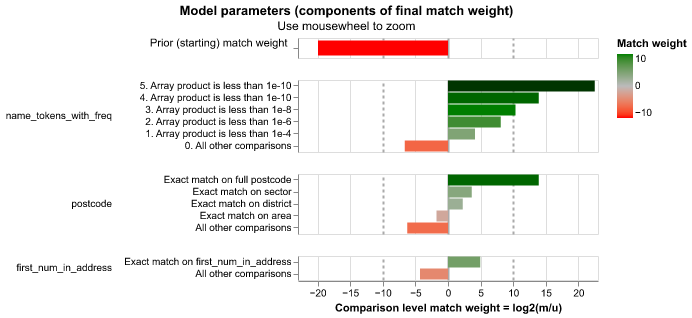

In [15]:
# Probably not worth training m values given how few columns we have;
# by not training them we'll be using the defaults

linker.training.estimate_u_using_random_sampling(max_pairs=1e7)
linker.visualisations.match_weights_chart()

In [16]:
# Get some results

df_predictions = linker.inference.predict(threshold_match_weight=-5)



# Since the companies house data is a canonical list, here we're taking the
# best matching company for each Stockport business
sql = f"""
WITH ranked_matches AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY unique_id_l ORDER BY match_weight DESC) as rank
    FROM {df_predictions.physical_name}
),
best_match as (
    select * from ranked_matches
    where rank = 1
    order by match_weight desc
),
matched_stockport_ids as (
    select distinct unique_id_l
    from best_match
)
select * from best_match

order by match_probability desc
"""

ranked_matches = con.sql(sql)
ranked_matches.show(max_rows=10, max_width=400)


Blocking time: 0.18 seconds


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Predict time: 3.65 seconds

 -- WARNING --
You have called predict(), but there are some parameter estimates which have neither been estimated or specified in your settings dictionary.  To produce predictions the following untrained trained parameters will use default values.
Comparison: 'name_tokens_with_freq':
    m values not fully trained
Comparison: 'postcode':
    m values not fully trained
Comparison: 'first_num_in_address':
    m values not fully trained


┌─────────────────────┬─────────────────────┬──────────────────┬──────────────────┬─────────────┬─────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬───┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┬───────────┬───────┐
│    match_weight     │  match_probability  │ source_dataset_l │ source_dataset_r │ unique_id_l │ unique_id_r │ name_tokens_with_f…  │ name_tokens_with_f…  │ gamma_name_tokens_…  │ bf_name_tokens_wit…  │ … │ first_num_in_addre…  │ gamma_first_num_in…  │ bf_first_num_in_ad…  │    company_name_l    │    company_name_r    │   rarest_tokens_l    │   rarest_tokens_r    │ match_key │ rank  │
│       double        │       double        │     varchar      │     varchar      │    int64    │    int64    │ struct(token varch…  │ struct(token varch…  │        int32         │        double        │   │       varchar 

┌────────────────────┬──────────────────┬─────────────┬─────────────────────────────────────────────────┬────────────┬────────────────────────┬────────────────────────────────┬───────────────────────┐
│ match_probability  │ source_dataset_l │ unique_id_l │             name_tokens_with_freq_l             │ postcode_l │ first_num_in_address_l │         company_name_l         │    rarest_tokens_l    │
│       double       │     varchar      │    int64    │     struct(token varchar, rel_freq float)[]     │  varchar   │        varchar         │            varchar             │       varchar[]       │
├────────────────────┼──────────────────┼─────────────┼─────────────────────────────────────────────────┼────────────┼────────────────────────┼────────────────────────────────┼───────────────────────┤
│ 0.9998652868923441 │ stockport        │         872 │ [{'token': CLARITAS, 'rel_freq': 1.9255674e-0…  │ SK4 4DT    │ 10                     │ CLARITAS WEALTH MANAGMENT LTD  │ [CLARITAS, MANAGMEN

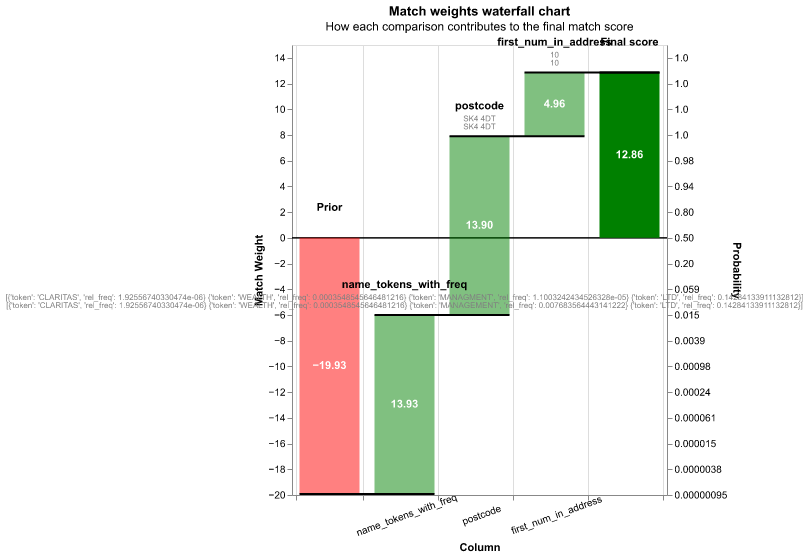

In [17]:
sql = """
CREATE OR REPLACE TABLE comparison AS
select * from ranked_matches
where company_name_l != company_name_r
order by random()
limit 1
"""
duckdb.execute(sql)


sql = """
SELECT match_probability, COLUMNS('^(t[^f_].*|b[^f_].*|[^tb].*_l)$') AS '\\1'
FROM comparison
UNION ALL
SELECT match_probability, COLUMNS('^(t[^f_].*|b[^f_].*|[^tb].*_r)$') AS '\\1'
FROM comparison;
"""
duckdb.sql(sql).show(max_rows=10, max_width=200)

recs = duckdb.table("comparison").df().to_dict(orient="records")
linker.visualisations.waterfall_chart(recs)


┌──────────────┬───────────────────┐
│ match_weight │ match_probability │
│    int32     │   decimal(2,1)    │
├──────────────┼───────────────────┤
│          -10 │               0.0 │
│          -10 │               0.0 │
│          -10 │               0.0 │
│          -10 │               0.0 │
│          -10 │               0.0 │
│           ·  │                ·  │
│           ·  │                ·  │
│           ·  │                ·  │
│          -10 │               0.0 │
│          -10 │               0.0 │
│          -10 │               0.0 │
│          -10 │               0.0 │
│          -10 │               0.0 │
├──────────────┴───────────────────┤
│ 1783 rows (10 shown)   2 columns │
└──────────────────────────────────┘



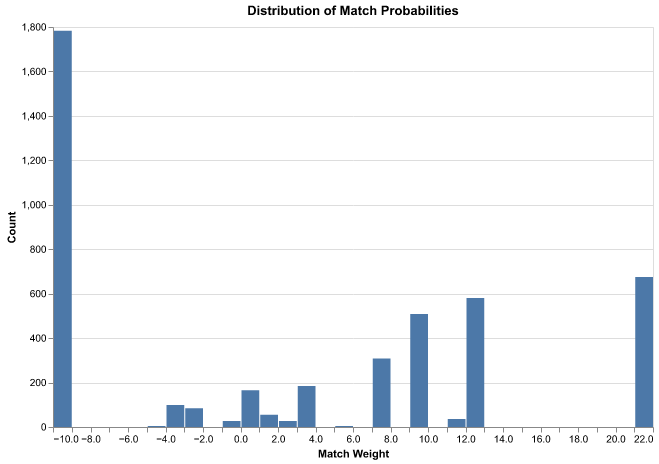

In [18]:
import altair as alt
# Plot histogram of match weights

# This list does not include any stockport records where no comparison pairs were made
# because blocking rules did not find any potential matches

# Add in unmatched records
sql = """
WITH matched_stockport_ids as (
    select distinct unique_id_l
    from ranked_matches
)
select
    -10 as match_weight,
    0.0 as match_probability,
from data_for_matching t
where t.source_dataset = 'stockport'
and t.unique_id not in (select unique_id_l from matched_stockport_ids)
"""

unmatched_records = duckdb.sql(sql)
unmatched_records.show(max_rows=10, max_width=400)


sql = """
select match_probability, match_weight from ranked_matches
union all
select match_probability, match_weight from unmatched_records
order by match_probability desc
"""

all_records = con.sql(sql)

# Create the histogram
chart = (
    alt.Chart(all_records.df())
    .mark_bar()
    .encode(
        alt.X("match_weight:Q", bin=alt.Bin(maxbins=50), title="Match Weight"),
        alt.Y("count():Q", title="Count"),
    )
    .properties(title="Distribution of Match Probabilities", width=600, height=400)
)

# Save the chart
chart



## Extensions and final notes

When running this against the full companies house data rather than the small subset here, the number of unmatched records (the bar on the left hand side of the histogram) reduces to about 890 records.

There are a number of ways the accuracy of this example could be improved:

- Additional data cleaning, e.g. dealing better with company names like A B C Engineering vs ABC engineering, or translating word aliases like LTD to LIMITED
- A more sophisticated approach to tokenisation
- Blocking could be improved in various ways, e.g. by blocking on address tokens, using more 'rare' tokens, using partial postcodes better and so on
- Allowing fuzzy matching on tokens in the company name, not just full token matching
